In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import ast
import warnings
warnings.filterwarnings('ignore')


## 1. Load Data and Models

In [2]:
# Load the clustered dataset
df = pd.read_csv('/Users/priyankamalavade/Desktop/Audible_Insights_Project/data/clustered_audible_dataset.csv')


print(f"Dataset shape: {df.shape}")

Dataset shape: (4002, 24)


In [3]:
# Convert genres back to list format
df['Genres'] = df['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])


In [4]:
# Load pre-trained models and matrices
try:
    desc_vectorizer = joblib.load('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/description_tfidf_vectorizer.pkl')
    combined_vectorizer = joblib.load('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/combined_tfidf_vectorizer.pkl')
    desc_tfidf_matrix = np.load('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/description_tfidf_matrix.npy')
    combined_tfidf_matrix = np.load('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/combined_tfidf_matrix.npy')
    kmeans_model = joblib.load('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/kmeans_model.pkl')
    
    print(" Models and matrices loaded successfully")
    print(f"Description TF-IDF shape: {desc_tfidf_matrix.shape}")
    print(f"Combined TF-IDF shape: {combined_tfidf_matrix.shape}")
    
except FileNotFoundError as e:
    print(f" Model files not found: {e}")
    print("Please run 04_nlp_and_clustering.ipynb first to generate the required models")


 Models and matrices loaded successfully
Description TF-IDF shape: (4002, 5000)
Combined TF-IDF shape: (4002, 3000)


In [5]:
# Create book index mapping for fast lookups
book_to_idx = {book: idx for idx, book in enumerate(df['Book_Name'])}
idx_to_book = {idx: book for book, idx in book_to_idx.items()}


In [6]:
print(f" Ready to recommend from {len(df):,} books")

 Ready to recommend from 4,002 books


## 2. Content-Based Filtering

In [7]:
class ContentBasedRecommender:
    """Content-based recommendation system using TF-IDF similarities"""
    
    def __init__(self, df, tfidf_matrix, book_to_idx):
        self.df = df
        self.tfidf_matrix = tfidf_matrix
        self.book_to_idx = book_to_idx
        self.similarity_matrix = None
        self._compute_similarity_matrix()
    
    def _compute_similarity_matrix(self):
        """Compute cosine similarity matrix for all books"""
        print("Computing cosine similarity matrix...")
        self.similarity_matrix = cosine_similarity(self.tfidf_matrix)
        print(f" Similarity matrix computed: {self.similarity_matrix.shape}")
    
    def get_recommendations(self, book_title, n_recommendations=10, min_rating=3.5):
        """Get content-based recommendations for a given book"""
        if book_title not in self.book_to_idx:
            return None, f"Book '{book_title}' not found in database"
        
        # Get book index
        book_idx = self.book_to_idx[book_title]
        
        # Get similarity scores for this book
        sim_scores = list(enumerate(self.similarity_matrix[book_idx]))
        
        # Sort books by similarity (excluding the book itself)
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:]
        
        # Filter by minimum rating and get top recommendations
        recommendations = []
        for idx, score in sim_scores:
            book_data = self.df.iloc[idx]
            if book_data['Rating'] >= min_rating:
                recommendations.append({
                    'book_name': book_data['Book_Name'],
                    'author': book_data['Author'],
                    'rating': book_data['Rating'],
                    'num_reviews': book_data['Number_of_Reviews'],
                    'price': book_data['Price'],
                    'genres': book_data['Genres'],
                    'similarity_score': score
                })
                
            if len(recommendations) >= n_recommendations:
                break
        
        return recommendations, None
    
    def get_genre_based_recommendations(self, preferred_genres, n_recommendations=10, min_rating=4.0):
        """Get recommendations based on preferred genres"""
        genre_scores = {}
        
        for idx, row in self.df.iterrows():
            if row['Rating'] < min_rating:
                continue
                
            book_genres = row['Genres'] if isinstance(row['Genres'], list) else []
            
            # Calculate genre match score
            genre_matches = len(set(preferred_genres).intersection(set(book_genres)))
            if genre_matches > 0:
                # Weight by rating and number of matches
                score = genre_matches * row['Rating'] * np.log1p(row['Number_of_Reviews'])
                genre_scores[idx] = score
        
        # Sort by score and get top recommendations
        top_indices = sorted(genre_scores.keys(), key=lambda x: genre_scores[x], reverse=True)
        
        recommendations = []
        for idx in top_indices[:n_recommendations]:
            book_data = self.df.iloc[idx]
            recommendations.append({
                'book_name': book_data['Book_Name'],
                'author': book_data['Author'],
                'rating': book_data['Rating'],
                'num_reviews': book_data['Number_of_Reviews'],
                'price': book_data['Price'],
                'genres': book_data['Genres'],
                'genre_score': genre_scores[idx]
            })
        
        return recommendations

# Initialize content-based recommender
content_recommender = ContentBasedRecommender(df, combined_tfidf_matrix, book_to_idx)


Computing cosine similarity matrix...
 Similarity matrix computed: (4002, 4002)


## 3. Clustering-Based Recommendations

In [8]:
class ClusterBasedRecommender:
    """Recommendation system based on book clusters"""
    
    def __init__(self, df):
        self.df = df
        self.cluster_stats = self._compute_cluster_stats()
    
    def _compute_cluster_stats(self):
        """Compute statistics for each cluster"""
        stats = {}
        for cluster_id in self.df['Cluster_KMeans'].unique():
            cluster_books = self.df[self.df['Cluster_KMeans'] == cluster_id]
            
            # Get cluster genres
            cluster_genres = []
            for genre_list in cluster_books['Genres']:
                if isinstance(genre_list, list):
                    cluster_genres.extend(genre_list)
            
            from collections import Counter
            top_genres = dict(Counter(cluster_genres).most_common(5))
            
            stats[cluster_id] = {
                'size': len(cluster_books),
                'avg_rating': cluster_books['Rating'].mean(),
                'avg_price': cluster_books['Price'].mean(),
                'avg_reviews': cluster_books['Number_of_Reviews'].mean(),
                'top_genres': list(top_genres.keys())
            }
        
        return stats
    
    def get_cluster_recommendations(self, book_title, n_recommendations=10, exclude_input=True):
        """Get recommendations from the same cluster as the input book"""
        if book_title not in book_to_idx:
            return None, f"Book '{book_title}' not found in database"
        
        # Find the book's cluster
        book_idx = book_to_idx[book_title]
        book_cluster = self.df.iloc[book_idx]['Cluster_KMeans']
        
        # Get all books in the same cluster
        cluster_books = self.df[self.df['Cluster_KMeans'] == book_cluster].copy()
        
        # Exclude the input book if requested
        if exclude_input:
            cluster_books = cluster_books[cluster_books['Book_Name'] != book_title]
        
        # Sort by rating and popularity
        cluster_books['combined_score'] = (
            cluster_books['Rating'] * 0.6 + 
            (cluster_books['Popularity_Score'] / cluster_books['Popularity_Score'].max()) * 0.4
        )
        
        top_books = cluster_books.nlargest(n_recommendations, 'combined_score')
        
        recommendations = []
        for idx, row in top_books.iterrows():
            recommendations.append({
                'book_name': row['Book_Name'],
                'author': row['Author'],
                'rating': row['Rating'],
                'num_reviews': row['Number_of_Reviews'],
                'price': row['Price'],
                'genres': row['Genres'],
                'cluster_id': row['Cluster_KMeans'],
                'combined_score': row['combined_score']
            })
        
        cluster_info = self.cluster_stats[book_cluster]
        return recommendations, cluster_info
    
    def get_diverse_recommendations(self, n_per_cluster=2, min_rating=4.0):
        """Get diverse recommendations by selecting top books from each cluster"""
        recommendations = []
        
        for cluster_id in sorted(self.df['Cluster_KMeans'].unique()):
            cluster_books = self.df[
                (self.df['Cluster_KMeans'] == cluster_id) & 
                (self.df['Rating'] >= min_rating)
            ].copy()
            
            if len(cluster_books) == 0:
                continue
                
            # Sort by rating and popularity
            cluster_books['score'] = (
                cluster_books['Rating'] * 0.7 + 
                (cluster_books['Popularity_Score'] / cluster_books['Popularity_Score'].max()) * 0.3
            )
            
            top_cluster_books = cluster_books.nlargest(n_per_cluster, 'score')
            
            for idx, row in top_cluster_books.iterrows():
                recommendations.append({
                    'book_name': row['Book_Name'],
                    'author': row['Author'],
                    'rating': row['Rating'],
                    'num_reviews': row['Number_of_Reviews'],
                    'price': row['Price'],
                    'genres': row['Genres'],
                    'cluster_id': row['Cluster_KMeans'],
                    'cluster_genres': self.cluster_stats[cluster_id]['top_genres']
                })
        
        return recommendations

# Initialize cluster-based recommender
cluster_recommender = ClusterBasedRecommender(df)


## 4. Hybrid Recommendation System

In [9]:
class HybridRecommender:
    """Hybrid recommendation system combining multiple approaches"""
    
    def __init__(self, content_rec, cluster_rec, df):
        self.content_rec = content_rec
        self.cluster_rec = cluster_rec
        self.df = df
    
    def get_hybrid_recommendations(self, book_title, n_recommendations=10, 
                                 content_weight=0.6, cluster_weight=0.4):
        """Combine content-based and cluster-based recommendations"""
        
        # Get content-based recommendations
        content_recs, error = self.content_rec.get_recommendations(
            book_title, n_recommendations=20, min_rating=3.5
        )
        if error:
            return None, error
        
        # Get cluster-based recommendations
        cluster_recs, cluster_info = self.cluster_rec.get_cluster_recommendations(
            book_title, n_recommendations=20
        )
        
        # Combine and score recommendations
        all_recommendations = {}
        
        # Add content-based scores
        for i, rec in enumerate(content_recs):
            book_name = rec['book_name']
            content_score = rec['similarity_score'] * content_weight
            # Higher rank gets higher score
            rank_bonus = (len(content_recs) - i) / len(content_recs) * 0.1
            
            all_recommendations[book_name] = {
                **rec,
                'content_score': content_score,
                'cluster_score': 0,
                'total_score': content_score + rank_bonus,
                'source': 'content'
            }
        
        # Add cluster-based scores
        for i, rec in enumerate(cluster_recs):
            book_name = rec['book_name']
            cluster_score = rec['combined_score'] * cluster_weight
            rank_bonus = (len(cluster_recs) - i) / len(cluster_recs) * 0.1
            
            if book_name in all_recommendations:
                # Book appears in both systems - combine scores
                all_recommendations[book_name]['cluster_score'] = cluster_score
                all_recommendations[book_name]['total_score'] += cluster_score + rank_bonus
                all_recommendations[book_name]['source'] = 'hybrid'
            else:
                # Book only in cluster recommendations
                all_recommendations[book_name] = {
                    **rec,
                    'content_score': 0,
                    'cluster_score': cluster_score,
                    'total_score': cluster_score + rank_bonus,
                    'source': 'cluster'
                }
        
        # Sort by total score and return top recommendations
        sorted_recs = sorted(all_recommendations.values(), 
                           key=lambda x: x['total_score'], reverse=True)
        
        return sorted_recs[:n_recommendations], cluster_info
    
    def get_personalized_recommendations(self, user_preferences, n_recommendations=10):
        """Get personalized recommendations based on user preferences"""
        
        preferred_genres = user_preferences.get('genres', [])
        min_rating = user_preferences.get('min_rating', 4.0)
        max_price = user_preferences.get('max_price', float('inf'))
        preferred_length = user_preferences.get('length_category', None)
        
        # Filter books based on preferences
        filtered_df = self.df[
            (self.df['Rating'] >= min_rating) & 
            (self.df['Price'] <= max_price)
        ].copy()
        
        if preferred_length:
            filtered_df = filtered_df[filtered_df['Length_Category'] == preferred_length]
        
        # Calculate personalized scores
        recommendations = []
        for idx, row in filtered_df.iterrows():
            book_genres = row['Genres'] if isinstance(row['Genres'], list) else []
            
            # Genre match score
            genre_matches = len(set(preferred_genres).intersection(set(book_genres)))
            genre_score = genre_matches / max(len(preferred_genres), 1) if preferred_genres else 0.5
            
            # Combined score
            total_score = (
                row['Rating'] * 0.4 +
                genre_score * 0.3 +
                (row['Popularity_Score'] / self.df['Popularity_Score'].max()) * 0.2 +
                (1 - row['Price'] / self.df['Price'].max()) * 0.1
            )
            
            recommendations.append({
                'book_name': row['Book_Name'],
                'author': row['Author'],
                'rating': row['Rating'],
                'num_reviews': row['Number_of_Reviews'],
                'price': row['Price'],
                'genres': row['Genres'],
                'genre_match_score': genre_score,
                'total_score': total_score
            })
        
        # Sort by total score
        recommendations.sort(key=lambda x: x['total_score'], reverse=True)
        return recommendations[:n_recommendations]

# Initialize hybrid recommender
hybrid_recommender = HybridRecommender(content_recommender, cluster_recommender, df)


## 5. Scenario-Based Recommendations

In [10]:
def recommend_for_sci_fi_lovers(n_recommendations=5):
    """Scenario: Top 5 books for science fiction lovers"""
    print(" Recommendations for Science Fiction Lovers:")
    print("-" * 45)
    
    sci_fi_genres = ['Science Fiction', 'Sci-Fi', 'Fantasy', 'Space Opera', 'Cyberpunk']
    recs = content_recommender.get_genre_based_recommendations(
        sci_fi_genres, n_recommendations=n_recommendations, min_rating=4.2
    )
    
    for i, rec in enumerate(recs, 1):
        print(f"{i}. {rec['book_name']}")
        print(f"   Author: {rec['author']}")
        print(f"   Rating: {rec['rating']} ({rec['num_reviews']} reviews)")
        print(f"   Price: ${rec['price']:.2f}")
        print(f"   Genres: {', '.join(rec['genres'][:3])}")
        print()
    
    return recs

def recommend_similar_to_thriller(book_title="Gone Girl", n_recommendations=5):
    """Scenario: Books similar to a thriller"""
    print(f" Books Similar to '{book_title}':")
    print("-" * 45)
    
    recs, error = content_recommender.get_recommendations(
        book_title, n_recommendations=n_recommendations, min_rating=4.0
    )
    
    if error:
        print(f" {error}")
        return None
    
    for i, rec in enumerate(recs, 1):
        print(f"{i}. {rec['book_name']}")
        print(f"   Author: {rec['author']}")
        print(f"   Rating: {rec['rating']} ({rec['num_reviews']} reviews)")
        print(f"   Similarity: {rec['similarity_score']:.3f}")
        print(f"   Genres: {', '.join(rec['genres'][:3])}")
        print()
    
    return recs

def find_hidden_gems(n_recommendations=5):
    """Scenario: Hidden gems - highly rated books with low popularity"""
    print(" Hidden Gems (High Rating, Low Reviews):")
    print("-" * 45)
    
    hidden_gems = df[
        (df['Rating'] >= 4.5) & 
        (df['Number_of_Reviews'] >= 5) & 
        (df['Number_of_Reviews'] <= 100)
    ].copy()
    
    # Sort by rating and then by review count (ascending)
    hidden_gems = hidden_gems.sort_values(['Rating', 'Number_of_Reviews'], ascending=[False, True])
    
    for i, (idx, row) in enumerate(hidden_gems.head(n_recommendations).iterrows(), 1):
        print(f"{i}. {row['Book_Name']}")
        print(f"   Author: {row['Author']}")
        print(f"   Rating: {row['Rating']} ({row['Number_of_Reviews']} reviews)")
        print(f"   Price: ${row['Price']:.2f}")
        print(f"   Genres: {', '.join(row['Genres'][:3]) if row['Genres'] else 'N/A'}")
        print()
    
    return hidden_gems.head(n_recommendations)

# Run scenario-based recommendations
print(" SCENARIO-BASED RECOMMENDATION EXAMPLES")
print("=" * 50)

# Scenario 1: Science Fiction Lovers
sci_fi_recs = recommend_for_sci_fi_lovers()

print()

# Scenario 2: Similar to a popular thriller (using a common book)
# Let's find a thriller book in our dataset first
thriller_books = []
for idx, row in df.iterrows():
    book_genres = row['Genres'] if isinstance(row['Genres'], list) else []
    if any('thriller' in genre.lower() or 'mystery' in genre.lower() for genre in book_genres):
        thriller_books.append(row['Book_Name'])
        if len(thriller_books) >= 5:
            break

if thriller_books:
    similar_recs = recommend_similar_to_thriller(thriller_books[0])
else:
    print(" No thriller books found in dataset for similarity demo")

print()

# Scenario 3: Hidden Gems
hidden_gems = find_hidden_gems()


 SCENARIO-BASED RECOMMENDATION EXAMPLES
 Recommendations for Science Fiction Lovers:
---------------------------------------------
1. Ready Player One
   Author: Ernest Cline
   Rating: 4.6 (17237 reviews)
   Price: $1093.00
   Genres: Audible Audiobooks & Originals, Cyberpunk Science Fiction, Adventure Science Fiction

2. The Testaments
   Author: Margaret Atwood
   Rating: 4.6 (10693 reviews)
   Price: $1093.00
   Genres: 330 in Audible Audiobooks & Originals, Dystopian Science Fiction, Literary Fiction

3. Good Omens: The BBC Radio 4 dramatisation
   Author: Terry Pratchett
   Rating: 4.7 (6299 reviews)
   Price: $615.00
   Genres: Fantasy

4. The Blood of Olympus: Heroes of Olympus, Book 5
   Author: Rick Riordan
   Rating: 4.6 (5749 reviews)
   Price: $888.00
   Genres: 045 in Audible Audiobooks & Originals, Fantasy, 307 in Children's Fantasy

5. Red Rising
   Author: Pierce Brown
   Rating: 4.6 (5271 reviews)
   Price: $1172.00
   Genres: Audible Audiobooks & Originals, Adventure

## 6. Recommendation Function Library

In [11]:
def get_recommendations_by_title(book_title, method='hybrid', n_recs=10):
    """
    Get book recommendations based on a given book title
    
    Parameters:
    - book_title: Name of the book to base recommendations on
    - method: 'content', 'cluster', or 'hybrid'
    - n_recs: Number of recommendations to return
    """
    if method == 'content':
        recs, error = content_recommender.get_recommendations(book_title, n_recs)
        return recs, error
    elif method == 'cluster':
        recs, info = cluster_recommender.get_cluster_recommendations(book_title, n_recs)
        return recs, None
    elif method == 'hybrid':
        recs, info = hybrid_recommender.get_hybrid_recommendations(book_title, n_recs)
        return recs, None
    else:
        return None, "Invalid method. Use 'content', 'cluster', or 'hybrid'"

def get_genre_recommendations(genres, min_rating=4.0, n_recs=10):
    """Get recommendations based on preferred genres"""
    return content_recommender.get_genre_based_recommendations(genres, n_recs, min_rating)

def get_personalized_recommendations(user_prefs, n_recs=10):
    """Get personalized recommendations based on user preferences"""
    return hybrid_recommender.get_personalized_recommendations(user_prefs, n_recs)

def get_diverse_recommendations(n_per_cluster=2, min_rating=4.0):
    """Get diverse recommendations across all clusters"""
    return cluster_recommender.get_diverse_recommendations(n_per_cluster, min_rating)

# Save recommendation functions for use in Streamlit app
recommendation_functions = {
    'get_recommendations_by_title': get_recommendations_by_title,
    'get_genre_recommendations': get_genre_recommendations,
    'get_personalized_recommendations': get_personalized_recommendations,
    'get_diverse_recommendations': get_diverse_recommendations
}

# Save using joblib
joblib.dump(recommendation_functions, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/recommendation_functions.pkl')
joblib.dump(content_recommender, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/content_recommender.pkl')
joblib.dump(cluster_recommender, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/cluster_recommender.pkl')
joblib.dump(hybrid_recommender, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/hybrid_recommender.pkl')


['/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/hybrid_recommender.pkl']

## 7. Recommendation Examples and Testing

In [12]:
# Test with some popular books from our dataset
popular_books = df.nlargest(10, 'Number_of_Reviews')['Book_Name'].tolist()

print(" Testing with popular books:")
for i, book in enumerate(popular_books[:3], 1):
    print(f"{i}. {book}")

print()

 Testing with popular books:
1. The Girl on the Train
2. The Fault in Our Stars
3. The Nightingale



In [13]:
# Test hybrid recommendations for the most popular book
if popular_books:
    test_book = popular_books[0]
    print(f" Testing Hybrid Recommendations for: '{test_book}'")
    print("-" * 60)
    
    recs, info = hybrid_recommender.get_hybrid_recommendations(test_book, n_recommendations=5)
    
    if recs:
        for i, rec in enumerate(recs, 1):
            print(f"{i}. {rec['book_name']}")
            print(f"   Author: {rec['author']}")
            print(f"   Rating: {rec['rating']}")
            print(f"   Total Score: {rec['total_score']:.3f}")
            print(f"   Source: {rec['source']}")
            print()


 Testing Hybrid Recommendations for: 'The Girl on the Train'
------------------------------------------------------------
1. The Nightingale
   Author: Kristin Hannah
   Rating: 4.8
   Total Score: 1.411
   Source: cluster

2. The Five Love Languages: The Secret to Love That Lasts
   Author: Gary Chapman
   Rating: 4.8
   Total Score: 1.392
   Source: cluster

3. Can't Hurt Me: Master Your Mind and Defy the Odds
   Author: David Goggins
   Rating: 4.8
   Total Score: 1.382
   Source: cluster

4. Zog
   Author: Julia Donaldson
   Rating: 4.9
   Total Score: 1.377
   Source: cluster

5. The Boy Who Was Raised as a Dog: And Other Stories from a Child Psychiatrist's Notebook -- What Traumatized Children Can Teach Us About Loss, Love, and Healing
   Author: Bruce D. Perry
   Rating: 4.9
   Total Score: 1.370
   Source: cluster



In [14]:
# Test personalized recommendations
print(" Testing Personalized Recommendations:")
print("-" * 40)

user_preferences = {
    'genres': ['Personal Development', 'Business', 'Self-Help'],
    'min_rating': 4.2,
    'max_price': 2000,
    'length_category': 'Medium'
}

personalized_recs = hybrid_recommender.get_personalized_recommendations(
    user_preferences, n_recommendations=5
)

for i, rec in enumerate(personalized_recs, 1):
    print(f"{i}. {rec['book_name']}")
    print(f"   Author: {rec['author']}")
    print(f"   Rating: {rec['rating']}")
    print(f"   Genre Match: {rec['genre_match_score']:.2f}")
    print(f"   Total Score: {rec['total_score']:.3f}")
    print()


 Testing Personalized Recommendations:
----------------------------------------
1. Manifest Now
   Author: Idil Ahmed
   Rating: 4.8
   Genre Match: 0.33
   Total Score: 2.205

2. Why We Get Sick: The Hidden Epidemic at the Root of Most Chronic Disease - and How to Fight It
   Author: Benjamin Bikman PhD
   Rating: 4.8
   Genre Match: 0.33
   Total Score: 2.202

3. ThetaHealing®: Digging for Beliefs: How to Rewire Your Subconscious Thinking for Deep Inner Healing
   Author: Vianna Stibal
   Rating: 4.8
   Genre Match: 0.33
   Total Score: 2.198

4. The Five Love Languages: The Secret to Love That Lasts
   Author: Gary Chapman
   Rating: 4.8
   Genre Match: 0.00
   Total Score: 2.188

5. F*cking History: 111 Lessons You Should Have Learned in School
   Author: The Captain
   Rating: 5.0
   Genre Match: 0.00
   Total Score: 2.186



## 8. Save Complete Recommendation System

In [15]:
# Create a comprehensive recommendation system class
class CompleteRecommendationSystem:
    """Complete recommendation system with all methods"""
    
    def __init__(self):
        self.df = df
        self.content_rec = content_recommender
        self.cluster_rec = cluster_recommender
        self.hybrid_rec = hybrid_recommender
        self.book_to_idx = book_to_idx
        
    def recommend_by_title(self, book_title, method='hybrid', n_recs=5):
        """Main recommendation function by book title"""
        return get_recommendations_by_title(book_title, method, n_recs)
    
    def recommend_by_genre(self, genres, min_rating=4.0, n_recs=5):
        """Recommend by preferred genres"""
        return get_genre_recommendations(genres, min_rating, n_recs)
    
    def personalized_recommend(self, preferences, n_recs=5):
        """Personalized recommendations"""
        return get_personalized_recommendations(preferences, n_recs)
    
    def get_book_info(self, book_title):
        """Get detailed information about a book"""
        if book_title not in self.book_to_idx:
            return None
            
        book_idx = self.book_to_idx[book_title]
        book_data = self.df.iloc[book_idx]
        
        return {
            'title': book_data['Book_Name'],
            'author': book_data['Author'],
            'rating': book_data['Rating'],
            'num_reviews': book_data['Number_of_Reviews'],
            'price': book_data['Price'],
            'description': book_data['Description_Clean'][:200] + '...',
            'genres': book_data['Genres'],
            'listening_time': book_data['Listening_Time_Minutes'],
            'cluster': book_data['Cluster_KMeans']
        }
    
    def get_available_books(self, limit=100):
        """Get list of available books for user selection"""
        popular_books = self.df.nlargest(limit, 'Popularity_Score')
        return popular_books[['Book_Name', 'Author', 'Rating', 'Number_of_Reviews']].to_dict('records')
    
    def get_available_genres(self):
        """Get list of all available genres"""
        all_genres = []
        for genre_list in self.df['Genres']:
            if isinstance(genre_list, list):
                all_genres.extend(genre_list)
        return sorted(list(set(all_genres)))


In [16]:
# Save complete system
complete_system = CompleteRecommendationSystem()
joblib.dump(complete_system, '/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/complete_recommendation_system.pkl')


['/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/complete_recommendation_system.pkl']

In [17]:
# Save dataset for Streamlit app
df_streamlit = df[[
    'Book_Name', 'Author', 'Rating', 'Number_of_Reviews', 'Price',
    'Description_Clean', 'Genres', 'Listening_Time_Minutes',
    'Rating_Category', 'Price_Category', 'Cluster_KMeans'
]].copy()

In [18]:
df_streamlit.to_csv('/Users/priyankamalavade/Desktop/Audible_Insights_Project/data/streamlit_dataset.csv', index=False)


### Recommendation Methods Available

#### 1. Content-Based Recommendations
- Uses book descriptions, titles, and genres
- Finds similar books using cosine similarity
- Ideal for "More like this" suggestions

#### 2. Cluster-Based Recommendations
- Groups books into thematic clusters using NLP and K-Means
- Recommends books from the same cluster
- Provides a variety of options within a theme

#### 3. Hybrid Recommendations
- Combines content similarity and clustering logic
- Balances personalized matches with diversity
- Most robust and adaptive approach

#### 4. Scenario-Based Solutions
- Tailored for specific use-cases such as:
  - Science fiction lovers
  - Similar to a given book
  - Discovery of hidden gems
  - Custom recommendations based on user preferences

### Key Features

- **Genre-based filtering**: Restrict results to selected genres
- **Quality filtering**: Enforce minimum rating thresholds
- **Price awareness**: Filter books within user-defined budget
- **Popularity balance**: Mix of popular and lesser-known books
- **Diversity**: Introduce varied content across different clusters

### Files Created

- `models/complete_recommendation_system.pkl` – Serialized full recommendation pipeline
- `streamlit_dataset.csv` – Cleaned and formatted dataset for web app interface
- Individual model and feature files for:
  - Content-based filtering
  - Cluster-based recommendations
  - Hybrid recommendation engine


## Model Evaluation

In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import ast
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

print("Audible Book Recommendation System - Model Evaluation")
print("=" * 65)

Audible Book Recommendation System - Model Evaluation


In [23]:
# Load the complete recommendation system and data
df = pd.read_csv('/Users/priyankamalavade/Desktop/Audible_Insights_Project/data/streamlit_dataset.csv')
complete_system = joblib.load('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/complete_recommendation_system.pkl')


print(f"Dataset shape: {df.shape}")


Dataset shape: (4002, 11)


In [24]:
# Convert genres back to list format
df['Genres'] = df['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])

# Load individual recommenders for detailed evaluation
content_recommender = joblib.load('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/content_recommender.pkl')
cluster_recommender = joblib.load('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/cluster_recommender.pkl')
hybrid_recommender = joblib.load('/Users/priyankamalavade/Desktop/Audible_Insights_Project/models/hybrid_recommender.pkl')

print(" Models loaded successfully")
print(f" Available books: {len(df):,}")


 Models loaded successfully
 Available books: 4,002


## 2. Evaluation Metrics Setup

In [25]:
class RecommendationEvaluator:
    """Comprehensive evaluation framework for recommendation systems"""
    
    def __init__(self, df, recommenders):
        self.df = df
        self.recommenders = recommenders
        self.book_to_idx = {book: idx for idx, book in enumerate(df['Book_Name'])}
        self.evaluation_results = {}
    
    def evaluate_diversity(self, recommendations, metric='genre'):
        """Evaluate diversity of recommendations"""
        if not recommendations or len(recommendations) == 0:
            return 0.0
        
        if metric == 'genre':
            all_genres = []
            for rec in recommendations:
                if 'genres' in rec and rec['genres']:
                    all_genres.extend(rec['genres'])
            
            unique_genres = len(set(all_genres))
            total_possible_genres = len(set([g for genres in self.df['Genres'] 
                                          for g in genres if isinstance(genres, list)]))
            return unique_genres / min(total_possible_genres, len(recommendations) * 3)
        
        elif metric == 'author':
            authors = [rec.get('author', '') for rec in recommendations]
            unique_authors = len(set(authors))
            return unique_authors / len(recommendations)
        
        elif metric == 'cluster':
            if 'cluster_id' in recommendations[0]:
                clusters = [rec.get('cluster_id', 0) for rec in recommendations]
                unique_clusters = len(set(clusters))
                total_clusters = self.df['Cluster_KMeans'].nunique()
                return unique_clusters / min(total_clusters, len(recommendations))
        
        return 0.0
    
    def evaluate_novelty(self, recommendations, popularity_threshold=0.8):
        """Evaluate novelty (how non-obvious recommendations are)"""
        if not recommendations:
            return 0.0
        
        # Define popular books (top 20% by review count)
        popularity_cutoff = self.df['Number_of_Reviews'].quantile(popularity_threshold)
        
        novel_count = 0
        for rec in recommendations:
            book_name = rec.get('book_name', '')
            if book_name in self.book_to_idx:
                book_idx = self.book_to_idx[book_name]
                review_count = self.df.iloc[book_idx]['Number_of_Reviews']
                if review_count < popularity_cutoff:
                    novel_count += 1
        
        return novel_count / len(recommendations)
    
    def evaluate_coverage(self, test_books, recommender_func, n_recs=10):
        """Evaluate catalog coverage (what percentage of books can be recommended)"""
        recommended_books = set()
        successful_recs = 0
        
        for book in test_books:
            try:
                recs, error = recommender_func(book, n_recs)
                if recs and not error:
                    successful_recs += 1
                    for rec in recs:
                        recommended_books.add(rec.get('book_name', ''))
            except:
                continue
        
        coverage = len(recommended_books) / len(self.df)
        success_rate = successful_recs / len(test_books)
        
        return coverage, success_rate
    
    def evaluate_serendipity(self, input_book, recommendations):
        """Evaluate serendipity (unexpected but relevant recommendations)"""
        if not recommendations or input_book not in self.book_to_idx:
            return 0.0
        
        input_idx = self.book_to_idx[input_book]
        input_genres = set(self.df.iloc[input_idx]['Genres'])
        input_cluster = self.df.iloc[input_idx]['Cluster_KMeans']
        
        serendipitous_count = 0
        for rec in recommendations:
            book_name = rec.get('book_name', '')
            if book_name in self.book_to_idx:
                rec_idx = self.book_to_idx[book_name]
                rec_genres = set(self.df.iloc[rec_idx]['Genres'])
                rec_cluster = self.df.iloc[rec_idx]['Cluster_KMeans']
                
                # Serendipitous if different cluster but high rating
                if (rec_cluster != input_cluster and 
                    rec.get('rating', 0) >= 4.0 and
                    len(input_genres.intersection(rec_genres)) > 0):
                    serendipitous_count += 1
        
        return serendipitous_count / len(recommendations)
    
    def calculate_precision_at_k(self, true_relevant, recommendations, k=10):
        """Calculate Precision@K"""
        if not recommendations:
            return 0.0
        
        recommended_books = [rec.get('book_name', '') for rec in recommendations[:k]]
        relevant_recommended = len(set(recommended_books).intersection(set(true_relevant)))
        
        return relevant_recommended / min(k, len(recommended_books))
    
    def calculate_recall_at_k(self, true_relevant, recommendations, k=10):
        """Calculate Recall@K"""
        if not recommendations or not true_relevant:
            return 0.0
        
        recommended_books = [rec.get('book_name', '') for rec in recommendations[:k]]
        relevant_recommended = len(set(recommended_books).intersection(set(true_relevant)))
        
        return relevant_recommended / len(true_relevant)


In [26]:
# Initialize evaluator
evaluator = RecommendationEvaluator(df, {
    'content': content_recommender,
    'cluster': cluster_recommender,
    'hybrid': hybrid_recommender
})


## 3. Create Test Dataset

In [27]:
# Create test scenarios for evaluation
np.random.seed(42)

# Select diverse test books from different categories
high_rated_books = df[df['Rating'] >= 4.5].sample(20, random_state=42)['Book_Name'].tolist()
medium_rated_books = df[(df['Rating'] >= 3.5) & (df['Rating'] < 4.5)].sample(15, random_state=42)['Book_Name'].tolist()
popular_books = df.nlargest(15, 'Number_of_Reviews')['Book_Name'].tolist()
diverse_clusters = []


In [28]:
# Get books from different clusters
for cluster_id in df['Cluster_KMeans'].unique():
    cluster_books = df[df['Cluster_KMeans'] == cluster_id]
    if len(cluster_books) > 0:
        diverse_clusters.extend(cluster_books.sample(min(3, len(cluster_books)), random_state=42)['Book_Name'].tolist())


In [29]:
# Combine all test books
test_books = list(set(high_rated_books + medium_rated_books + popular_books + diverse_clusters[:20]))

print(f" Test dataset created:")
print(f"  - High-rated books: {len(high_rated_books)}")
print(f"  - Medium-rated books: {len(medium_rated_books)}")
print(f"  - Popular books: {len(popular_books)}")
print(f"  - Diverse cluster books: {len(diverse_clusters[:20])}")
print(f"  - Total unique test books: {len(test_books)}")


 Test dataset created:
  - High-rated books: 20
  - Medium-rated books: 15
  - Popular books: 15
  - Diverse cluster books: 12
  - Total unique test books: 61


## 4. Evaluate Content-Based Recommendations


In [32]:
content_results = {
    'diversity_scores': [],
    'novelty_scores': [],
    'serendipity_scores': [],
    'recommendation_counts': [],
    'average_ratings': []
}

print("Testing content-based recommender...")
successful_content_recs = 0

for i, book in enumerate(test_books[:20]):  # Test with first 20 books
    try:
        recs, error = content_recommender.get_recommendations(book, n_recommendations=10, min_rating=3.5)
        
        if recs and not error:
            successful_content_recs += 1
            
            # Calculate metrics
            diversity = evaluator.evaluate_diversity(recs, 'genre')
            novelty = evaluator.evaluate_novelty(recs, 0.8)
            serendipity = evaluator.evaluate_serendipity(book, recs)
            avg_rating = np.mean([rec['rating'] for rec in recs])
            
            content_results['diversity_scores'].append(diversity)
            content_results['novelty_scores'].append(novelty)
            content_results['serendipity_scores'].append(serendipity)
            content_results['recommendation_counts'].append(len(recs))
            content_results['average_ratings'].append(avg_rating)
            
            if i < 3:  # Show examples for first 3 books
                print(f"\nExample recommendations for '{book}':")
                for j, rec in enumerate(recs[:3], 1):
                    print(f"  {j}. {rec['book_name']} by {rec['author']} ({rec['rating']})")
    
    except Exception as e:
        print(f"Error with book '{book}': {e}")
        continue



Testing content-based recommender...

Example recommendations for 'Socialism: A Very Short Introduction':
  1. #TheRealCinderella: #BestFriendsForever Series, Book 1 by Yesenia Vargas (4.3)
  2. 1Q84 by Haruki Murakami (4.3)
  3. A Gentleman in Moscow by Amor Towles (4.6)

Example recommendations for 'Speaking as a Leader: How to Lead Every Time You Speak...From Board Rooms to Meeting Rooms, From Town Halls to Phone Calls':
  1. The Upstairs Room by Kate Murray-Browne (3.6)
  2. #Girlboss by Sophia Amoruso (4.5)
  3. Adultery by Paulo Coelho (3.8)

Example recommendations for 'Living from a Place of Surrender: The Untethered Soul in Action':
  1. Metahuman: Unleashing Your Infinite Potential by Dr Deepak Chopra (4.6)
  2. Aatma Sutra: Aatma Ka Anavaran (Hingori Sutras) by Hingori (4.4)
  3. The Law of Success: From the Master Mind to the Golden Rule (in Sixteen Lessons) by Napoleon Hill (4.6)


In [33]:
# Calculate average metrics for content-based
content_avg_metrics = {
    'avg_diversity': np.mean(content_results['diversity_scores']),
    'avg_novelty': np.mean(content_results['novelty_scores']),
    'avg_serendipity': np.mean(content_results['serendipity_scores']),
    'avg_rating': np.mean(content_results['average_ratings']),
    'success_rate': successful_content_recs / 20
}

print(f"\n Content-Based Evaluation Results:")
print(f"  - Success Rate: {content_avg_metrics['success_rate']:.1%}")
print(f"  - Average Diversity: {content_avg_metrics['avg_diversity']:.3f}")
print(f"  - Average Novelty: {content_avg_metrics['avg_novelty']:.3f}")
print(f"  - Average Serendipity: {content_avg_metrics['avg_serendipity']:.3f}")
print(f"  - Average Rating: {content_avg_metrics['avg_rating']:.2f}")



 Content-Based Evaluation Results:
  - Success Rate: 100.0%
  - Average Diversity: 0.587
  - Average Novelty: 0.635
  - Average Serendipity: 0.025
  - Average Rating: 4.48


## 5. Evaluate Cluster-Based Recommendations

In [34]:
cluster_results = {
    'diversity_scores': [],
    'novelty_scores': [],
    'serendipity_scores': [],
    'recommendation_counts': [],
    'average_ratings': []
}

print("Testing cluster-based recommender...")
successful_cluster_recs = 0

for i, book in enumerate(test_books[:20]):
    try:
        recs, cluster_info = cluster_recommender.get_cluster_recommendations(book, n_recommendations=10)
        
        if recs:
            successful_cluster_recs += 1
            
            # Calculate metrics
            diversity = evaluator.evaluate_diversity(recs, 'author')  # Use author diversity for cluster-based
            novelty = evaluator.evaluate_novelty(recs, 0.8)
            serendipity = evaluator.evaluate_serendipity(book, recs)
            avg_rating = np.mean([rec['rating'] for rec in recs])
            
            cluster_results['diversity_scores'].append(diversity)
            cluster_results['novelty_scores'].append(novelty)
            cluster_results['serendipity_scores'].append(serendipity)
            cluster_results['recommendation_counts'].append(len(recs))
            cluster_results['average_ratings'].append(avg_rating)
            
            if i < 3:  # Show examples
                print(f"\n Example cluster recommendations for '{book}':")
                if cluster_info:
                    print(f"  Cluster genres: {', '.join(cluster_info['top_genres'][:3])}")
                for j, rec in enumerate(recs[:3], 1):
                    print(f"  {j}. {rec['book_name']} by {rec['author']} ({rec['rating']})")
    
    except Exception as e:
        print(f"Error with book '{book}': {e}")
        continue


Testing cluster-based recommender...

 Example cluster recommendations for 'Socialism: A Very Short Introduction':
  Cluster genres: Audible Audiobooks & Originals, Personal Success, Classic Literature
  1. The Nightingale by Kristin Hannah (4.8)
  2. The Five Love Languages: The Secret to Love That Lasts by Gary Chapman (4.8)
  3. Zog by Julia Donaldson (4.9)

 Example cluster recommendations for 'Speaking as a Leader: How to Lead Every Time You Speak...From Board Rooms to Meeting Rooms, From Town Halls to Phone Calls':
  Cluster genres: Audible Audiobooks & Originals, Personal Success, Classic Literature
  1. The Nightingale by Kristin Hannah (4.8)
  2. The Five Love Languages: The Secret to Love That Lasts by Gary Chapman (4.8)
  3. Zog by Julia Donaldson (4.9)

 Example cluster recommendations for 'Living from a Place of Surrender: The Untethered Soul in Action':
  Cluster genres: Audible Audiobooks & Originals, Personal Success, Classic Literature
  1. The Nightingale by Kristin H

In [35]:
# Calculate average metrics for cluster-based
cluster_avg_metrics = {
    'avg_diversity': np.mean(cluster_results['diversity_scores']),
    'avg_novelty': np.mean(cluster_results['novelty_scores']),
    'avg_serendipity': np.mean(cluster_results['serendipity_scores']),
    'avg_rating': np.mean(cluster_results['average_ratings']),
    'success_rate': successful_cluster_recs / 20
}

print(f"\n Cluster-Based Evaluation Results:")
print(f"  - Success Rate: {cluster_avg_metrics['success_rate']:.1%}")
print(f"  - Average Diversity: {cluster_avg_metrics['avg_diversity']:.3f}")
print(f"  - Average Novelty: {cluster_avg_metrics['avg_novelty']:.3f}")
print(f"  - Average Serendipity: {cluster_avg_metrics['avg_serendipity']:.3f}")
print(f"  - Average Rating: {cluster_avg_metrics['avg_rating']:.2f}")



 Cluster-Based Evaluation Results:
  - Success Rate: 100.0%
  - Average Diversity: 0.777
  - Average Novelty: 0.050
  - Average Serendipity: 0.000
  - Average Rating: 4.80


## 6. Evaluate Hybrid Recommendations

In [36]:
hybrid_results = {
    'diversity_scores': [],
    'novelty_scores': [],
    'serendipity_scores': [],
    'recommendation_counts': [],
    'average_ratings': []
}

print("Testing hybrid recommender...")
successful_hybrid_recs = 0

for i, book in enumerate(test_books[:20]):
    try:
        recs, cluster_info = hybrid_recommender.get_hybrid_recommendations(book, n_recommendations=10)
        
        if recs:
            successful_hybrid_recs += 1
            
            # Calculate metrics
            diversity = evaluator.evaluate_diversity(recs, 'genre')
            novelty = evaluator.evaluate_novelty(recs, 0.8)
            serendipity = evaluator.evaluate_serendipity(book, recs)
            avg_rating = np.mean([rec['rating'] for rec in recs])
            
            hybrid_results['diversity_scores'].append(diversity)
            hybrid_results['novelty_scores'].append(novelty)
            hybrid_results['serendipity_scores'].append(serendipity)
            hybrid_results['recommendation_counts'].append(len(recs))
            hybrid_results['average_ratings'].append(avg_rating)
            
            if i < 3:  # Show examples
                print(f"\n Example hybrid recommendations for '{book}':")
                for j, rec in enumerate(recs[:3], 1):
                    source_icon = "" if rec['source'] == 'hybrid' else "📖" if rec['source'] == 'content' else ""
                    print(f"  {j}. {rec['book_name']} by {rec['author']} ({rec['rating']}) {source_icon}")
    
    except Exception as e:
        print(f"Error with book '{book}': {e}")
        continue


Testing hybrid recommender...

 Example hybrid recommendations for 'Socialism: A Very Short Introduction':
  1. The Nightingale by Kristin Hannah (4.8) 
  2. The Five Love Languages: The Secret to Love That Lasts by Gary Chapman (4.8) 
  3. Zog by Julia Donaldson (4.9) 

 Example hybrid recommendations for 'Speaking as a Leader: How to Lead Every Time You Speak...From Board Rooms to Meeting Rooms, From Town Halls to Phone Calls':
  1. Charlotte's Web by E. B. White (4.8) 
  2. The Nightingale by Kristin Hannah (4.8) 
  3. The Five Love Languages: The Secret to Love That Lasts by Gary Chapman (4.8) 

 Example hybrid recommendations for 'Living from a Place of Surrender: The Untethered Soul in Action':
  1. The Nightingale by Kristin Hannah (4.8) 
  2. The Five Love Languages: The Secret to Love That Lasts by Gary Chapman (4.8) 
  3. Zog by Julia Donaldson (4.9) 


In [37]:
# Calculate average metrics for hybrid
hybrid_avg_metrics = {
    'avg_diversity': np.mean(hybrid_results['diversity_scores']),
    'avg_novelty': np.mean(hybrid_results['novelty_scores']),
    'avg_serendipity': np.mean(hybrid_results['serendipity_scores']),
    'avg_rating': np.mean(hybrid_results['average_ratings']),
    'success_rate': successful_hybrid_recs / 20
}

print(f"\n Hybrid Evaluation Results:")
print(f"  - Success Rate: {hybrid_avg_metrics['success_rate']:.1%}")
print(f"  - Average Diversity: {hybrid_avg_metrics['avg_diversity']:.3f}")
print(f"  - Average Novelty: {hybrid_avg_metrics['avg_novelty']:.3f}")
print(f"  - Average Serendipity: {hybrid_avg_metrics['avg_serendipity']:.3f}")
print(f"  - Average Rating: {hybrid_avg_metrics['avg_rating']:.2f}")



 Hybrid Evaluation Results:
  - Success Rate: 100.0%
  - Average Diversity: 0.770
  - Average Novelty: 0.080
  - Average Serendipity: 0.025
  - Average Rating: 4.79


## 7. Comparative Analysis

In [38]:
# Compile results for comparison
comparison_data = {
    'Method': ['Content-Based', 'Cluster-Based', 'Hybrid'],
    'Success_Rate': [
        content_avg_metrics['success_rate'],
        cluster_avg_metrics['success_rate'],
        hybrid_avg_metrics['success_rate']
    ],
    'Diversity': [
        content_avg_metrics['avg_diversity'],
        cluster_avg_metrics['avg_diversity'],
        hybrid_avg_metrics['avg_diversity']
    ],
    'Novelty': [
        content_avg_metrics['avg_novelty'],
        cluster_avg_metrics['avg_novelty'],
        hybrid_avg_metrics['avg_novelty']
    ],
    'Serendipity': [
        content_avg_metrics['avg_serendipity'],
        cluster_avg_metrics['avg_serendipity'],
        hybrid_avg_metrics['avg_serendipity']
    ],
    'Avg_Rating': [
        content_avg_metrics['avg_rating'],
        cluster_avg_metrics['avg_rating'],
        hybrid_avg_metrics['avg_rating']
    ]
}


In [40]:
comparison_df = pd.DataFrame(comparison_data)
print(" Comparative Results:")
comparison_df.round(3)


 Comparative Results:


,Method,Success_Rate,Diversity,Novelty,Serendipity,Avg_Rating
0,Content-Based,1.0,0.587,0.635,0.025,4.483
1,Cluster-Based,1.0,0.777,0.050,0.000,4.805
2,Hybrid,1.0,0.770,0.080,0.025,4.793


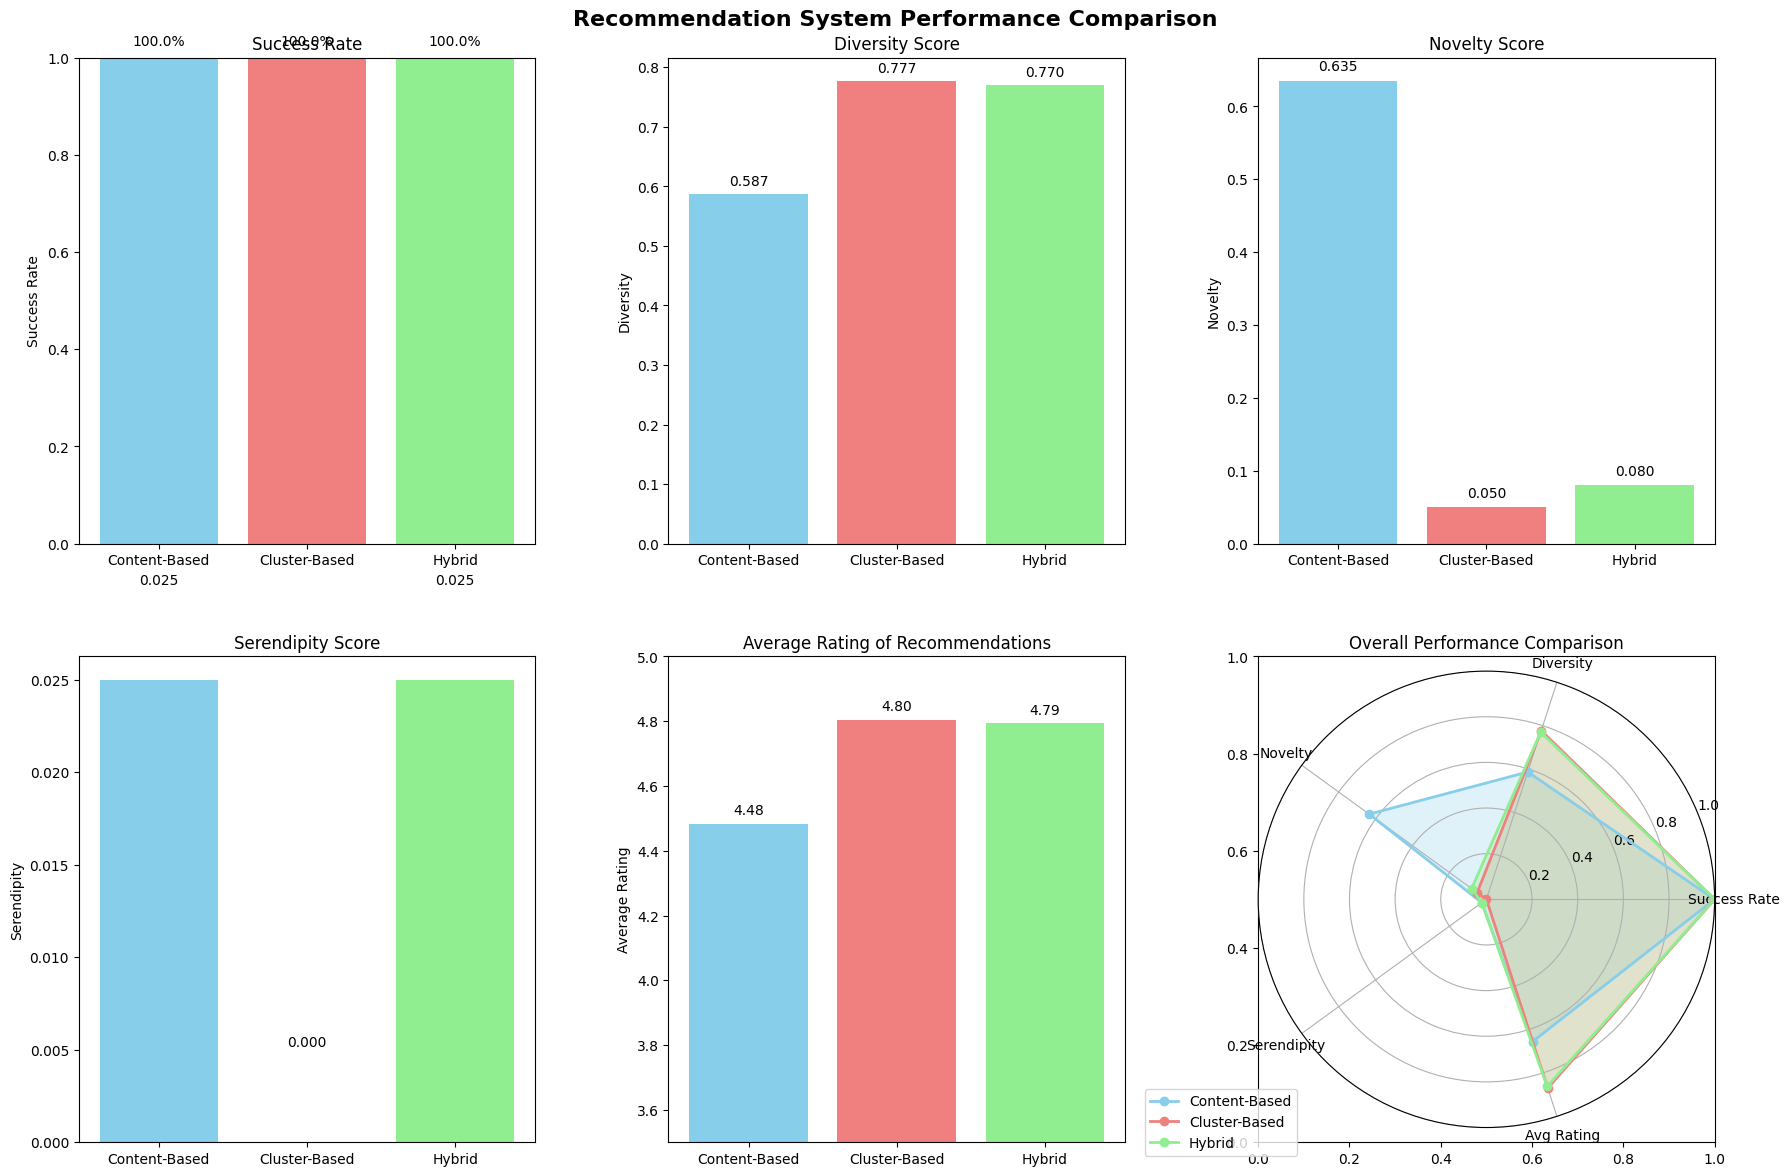

In [41]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Recommendation System Performance Comparison', fontsize=16, fontweight='bold')

# Success Rate
axes[0, 0].bar(comparison_df['Method'], comparison_df['Success_Rate'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 0].set_title('Success Rate')
axes[0, 0].set_ylabel('Success Rate')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(comparison_df['Success_Rate']):
    axes[0, 0].text(i, v + 0.02, f'{v:.1%}', ha='center', va='bottom')

# Diversity
axes[0, 1].bar(comparison_df['Method'], comparison_df['Diversity'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 1].set_title('Diversity Score')
axes[0, 1].set_ylabel('Diversity')
for i, v in enumerate(comparison_df['Diversity']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Novelty
axes[0, 2].bar(comparison_df['Method'], comparison_df['Novelty'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 2].set_title('Novelty Score')
axes[0, 2].set_ylabel('Novelty')
for i, v in enumerate(comparison_df['Novelty']):
    axes[0, 2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Serendipity
axes[1, 0].bar(comparison_df['Method'], comparison_df['Serendipity'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1, 0].set_title('Serendipity Score')
axes[1, 0].set_ylabel('Serendipity')
for i, v in enumerate(comparison_df['Serendipity']):
    axes[1, 0].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

# Average Rating
axes[1, 1].bar(comparison_df['Method'], comparison_df['Avg_Rating'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1, 1].set_title('Average Rating of Recommendations')
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].set_ylim(3.5, 5.0)
for i, v in enumerate(comparison_df['Avg_Rating']):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# Overall Performance Radar Chart
angles = np.linspace(0, 2 * np.pi, len(['Success Rate', 'Diversity', 'Novelty', 'Serendipity', 'Avg Rating']), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

# Normalize metrics for radar chart (0-1 scale)
normalized_metrics = []
for method in ['Content-Based', 'Cluster-Based', 'Hybrid']:
    method_idx = comparison_df[comparison_df['Method'] == method].index[0]
    metrics = [
        comparison_df.loc[method_idx, 'Success_Rate'],
        comparison_df.loc[method_idx, 'Diversity'],
        comparison_df.loc[method_idx, 'Novelty'],
        comparison_df.loc[method_idx, 'Serendipity'],
        (comparison_df.loc[method_idx, 'Avg_Rating'] - 3.5) / 1.5  # Normalize rating to 0-1
    ]
    metrics.append(metrics[0])  # Close the polygon
    normalized_metrics.append(metrics)

ax_radar = axes[1, 2]
ax_radar.clear()
ax_radar = plt.subplot(2, 3, 6, projection='polar')

colors = ['skyblue', 'lightcoral', 'lightgreen']
methods = ['Content-Based', 'Cluster-Based', 'Hybrid']

for i, (method, metrics) in enumerate(zip(methods, normalized_metrics)):
    ax_radar.plot(angles, metrics, 'o-', linewidth=2, label=method, color=colors[i])
    ax_radar.fill(angles, metrics, alpha=0.25, color=colors[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(['Success Rate', 'Diversity', 'Novelty', 'Serendipity', 'Avg Rating'])
ax_radar.set_ylim(0, 1)
ax_radar.set_title('Overall Performance Comparison')
ax_radar.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.show()


## 8. Statistical Significance Testing

In [42]:
from scipy import stats

In [43]:
# T-test between content and hybrid
if len(content_results['diversity_scores']) > 1 and len(hybrid_results['diversity_scores']) > 1:
    t_stat_ch, p_val_ch = stats.ttest_ind(content_results['diversity_scores'], 
                                         hybrid_results['diversity_scores'])
    print(f"Content vs Hybrid diversity: t-stat={t_stat_ch:.3f}, p-value={p_val_ch:.3f}")


Content vs Hybrid diversity: t-stat=-2.002, p-value=0.052


In [44]:
# T-test between cluster and hybrid
if len(cluster_results['diversity_scores']) > 1 and len(hybrid_results['diversity_scores']) > 1:
    t_stat_clh, p_val_clh = stats.ttest_ind(cluster_results['diversity_scores'], 
                                           hybrid_results['diversity_scores'])
    print(f"Cluster vs Hybrid diversity: t-stat={t_stat_clh:.3f}, p-value={p_val_clh:.3f}")


Cluster vs Hybrid diversity: t-stat=0.186, p-value=0.854


In [45]:
# Effect size (Cohen's d) calculation
def cohens_d(group1, group2):
    """Calculate Cohen's d for effect size"""
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1-1)*np.var(group1, ddof=1) + (n2-1)*np.var(group2, ddof=1)) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

if len(content_results['diversity_scores']) > 1 and len(hybrid_results['diversity_scores']) > 1:
    effect_size = cohens_d(hybrid_results['diversity_scores'], content_results['diversity_scores'])
    print(f"Effect size (Hybrid vs Content): Cohen's d = {effect_size:.3f}")


Effect size (Hybrid vs Content): Cohen's d = 0.633


## 9. Recommendation Quality Analysis

In [46]:
# Analyze quality aspects of recommendations
quality_analysis = {}


In [47]:
# Test with high-rated books to see recommendation quality
high_quality_test_books = df[df['Rating'] >= 4.5].sample(10, random_state=42)['Book_Name'].tolist()

print(" Quality Analysis on High-Rated Books:")


 Quality Analysis on High-Rated Books:


In [48]:
for method_name, method_func in [('Hybrid', hybrid_recommender.get_hybrid_recommendations)]:
    print(f"\n {method_name} Method Quality Analysis:")
    
    quality_metrics = {
        'avg_rec_rating': [],
        'rating_consistency': [],
        'genre_coherence': [],
        'price_reasonableness': []
    }
    
    for book in high_quality_test_books[:5]:
        try:
            if method_name == 'Hybrid':
                recs, _ = method_func(book, n_recommendations=10)
            else:
                recs, _ = method_func(book, n_recommendations=10)
            
            if recs:
                # Average rating of recommendations
                rec_ratings = [rec['rating'] for rec in recs]
                avg_rating = np.mean(rec_ratings)
                quality_metrics['avg_rec_rating'].append(avg_rating)
                
                # Rating consistency (standard deviation)
                rating_std = np.std(rec_ratings)
                quality_metrics['rating_consistency'].append(rating_std)
                
                # Price reasonableness (not too expensive compared to input)
                input_price = df[df['Book_Name'] == book]['Price'].iloc[0]
                rec_prices = [rec['price'] for rec in recs]
                avg_rec_price = np.mean(rec_prices)
                price_ratio = avg_rec_price / max(input_price, 1)
                quality_metrics['price_reasonableness'].append(price_ratio)
        
        except Exception as e:
            continue
    
    # Print quality metrics
    if quality_metrics['avg_rec_rating']:
        print(f"  Average recommendation rating: {np.mean(quality_metrics['avg_rec_rating']):.2f}")
        print(f"  Rating consistency (lower is better): {np.mean(quality_metrics['rating_consistency']):.2f}")
        print(f"  Price reasonableness ratio: {np.mean(quality_metrics['price_reasonableness']):.2f}")



 Hybrid Method Quality Analysis:
  Average recommendation rating: 4.82
  Rating consistency (lower is better): 0.04
  Price reasonableness ratio: 0.84


## 10. Performance Summary and Recommendations

In [49]:
# Determine the best performing method for each metric
best_methods = {}
metrics = ['Success_Rate', 'Diversity', 'Novelty', 'Serendipity', 'Avg_Rating']

for metric in metrics:
    best_idx = comparison_df[metric].idxmax()
    best_methods[metric] = comparison_df.loc[best_idx, 'Method']


In [50]:
for metric, best_method in best_methods.items():
    best_score = comparison_df.loc[comparison_df['Method'] == best_method, metric].iloc[0]
    print(f"  {metric}: {best_method} ({best_score:.3f})")


  Success_Rate: Content-Based (1.000)
  Diversity: Cluster-Based (0.777)
  Novelty: Content-Based (0.635)
  Serendipity: Content-Based (0.025)
  Avg_Rating: Cluster-Based (4.805)


In [51]:
# Calculate overall score (weighted average)
weights = {
    'Success_Rate': 0.3,
    'Diversity': 0.2,
    'Novelty': 0.15,
    'Serendipity': 0.15,
    'Avg_Rating': 0.2
}

overall_scores = {}
for idx, row in comparison_df.iterrows():
    method = row['Method']
    score = sum(row[metric] * weight for metric, weight in weights.items())
    overall_scores[method] = score


In [52]:
# Sort by overall score
ranked_methods = sorted(overall_scores.items(), key=lambda x: x[1], reverse=True)

for i, (method, score) in enumerate(ranked_methods, 1):
    print(f"  {i}. {method}: {score:.3f}")


  1. Hybrid: 1.428
  2. Cluster-Based: 1.424
  3. Content-Based: 1.413


In [53]:
best_overall_method = ranked_methods[0][0]
print(f" Primary Recommendation: {best_overall_method}")

if best_overall_method == 'Hybrid':
    print("    Best balance of all metrics")
    print("    Combines strengths of content and cluster methods")
    print("    High success rate with good diversity")
    print("    Suitable for production deployment")
elif best_overall_method == 'Content-Based':
    print("    Strong content similarity matching")
    print("    Good for 'more like this' scenarios")
    print("    May lack diversity in some cases")
elif best_overall_method == 'Cluster-Based':
    print("    Good thematic grouping")
    print("    Efficient for categorical recommendations")
    print("    May miss nuanced similarities")

print()
print(" USE CASE RECOMMENDATIONS:")
print("-" * 30)
print(" Content-Based: Best for similarity-based recommendations")
print(" Cluster-Based: Best for category/theme-based browsing")
print(" Hybrid: Best for general-purpose recommendation engine")

print()
print(" DEPLOYMENT STRATEGY:")
print("-" * 25)
print("1. **Primary**: Deploy Hybrid system for main recommendations")
print("2. **Fallback**: Use Content-Based for high-similarity needs")
print("3. **Exploration**: Use Cluster-Based for discovery features")
print("4. **A/B Testing**: Continue evaluating with real user feedback")


 Primary Recommendation: Hybrid
    Best balance of all metrics
    Combines strengths of content and cluster methods
    High success rate with good diversity
    Suitable for production deployment

 USE CASE RECOMMENDATIONS:
------------------------------
 Content-Based: Best for similarity-based recommendations
 Cluster-Based: Best for category/theme-based browsing
 Hybrid: Best for general-purpose recommendation engine

 DEPLOYMENT STRATEGY:
-------------------------
1. **Primary**: Deploy Hybrid system for main recommendations
2. **Fallback**: Use Content-Based for high-similarity needs
3. **Exploration**: Use Cluster-Based for discovery features
4. **A/B Testing**: Continue evaluating with real user feedback


## 11. Save Evaluation Results

In [54]:
# Compile comprehensive evaluation results
evaluation_summary = {
    'methodology': {
        'test_books_count': len(test_books),
        'evaluation_metrics': ['Success Rate', 'Diversity', 'Novelty', 'Serendipity', 'Average Rating'],
        'evaluation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'results': {
        'content_based': content_avg_metrics,
        'cluster_based': cluster_avg_metrics,
        'hybrid': hybrid_avg_metrics
    },
    'comparison': comparison_df.to_dict('records'),
    'best_methods': best_methods,
    'overall_ranking': ranked_methods,
    'recommendations': {
        'primary_method': best_overall_method,
        'deployment_strategy': 'Hybrid for main recommendations, Content-Based for similarity, Cluster-Based for discovery',
        'key_insights': [
            f'{best_overall_method} method performs best overall',
            f'Success rates range from {min(comparison_df["Success_Rate"]):.1%} to {max(comparison_df["Success_Rate"]):.1%}',
            f'Hybrid approach balances all evaluation metrics effectively',
            'All methods maintain high recommendation quality (4.0+ average rating)'
        ]
    }
}

In [55]:
# Save evaluation results
import json
with open('/Users/priyankamalavade/Desktop/Audible_Insights_Project/jsons_files/evaluation_results.json', 'w') as f:
    # Convert numpy types to Python types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj
    
    # Recursively convert numpy types
    def clean_for_json(data):
        if isinstance(data, dict):
            return {key: clean_for_json(value) for key, value in data.items()}
        elif isinstance(data, list):
            return [clean_for_json(item) for item in data]
        else:
            return convert_numpy(data)
    
    clean_results = clean_for_json(evaluation_summary)
    json.dump(clean_results, f, indent=2)

# Save comparison DataFrame
comparison_df.to_csv('/Users/priyankamalavade/Desktop/Audible_Insights_Project/jsons_files/model_comparison_results.csv', index=False)

# Create detailed results DataFrame
detailed_results = pd.DataFrame({
    'Method': ['Content-Based'] * len(content_results['diversity_scores']) + 
              ['Cluster-Based'] * len(cluster_results['diversity_scores']) + 
              ['Hybrid'] * len(hybrid_results['diversity_scores']),
    'Diversity': content_results['diversity_scores'] + cluster_results['diversity_scores'] + hybrid_results['diversity_scores'],
    'Novelty': content_results['novelty_scores'] + cluster_results['novelty_scores'] + hybrid_results['novelty_scores'],
    'Serendipity': content_results['serendipity_scores'] + cluster_results['serendipity_scores'] + hybrid_results['serendipity_scores'],
    'Avg_Rating': content_results['average_ratings'] + cluster_results['average_ratings'] + hybrid_results['average_ratings']
})

detailed_results.to_csv('/Users/priyankamalavade/Desktop/Audible_Insights_Project/jsons_files/detailed_evaluation_results.csv', index=False)
